In [6357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [6359]:
df = pd.read_csv('TSCO_data.csv') wyjsciowe

In [6360]:
df

,date,open,high,low,close,volume,Name
0,2013-02-08,51.500,52.020,51.4700,52.020,1010132,TSCO
1,2013-02-11,51.770,51.970,51.3794,51.600,656296,TSCO
2,2013-02-12,51.705,51.820,51.2150,51.480,798632,TSCO
3,2013-02-13,51.325,51.600,51.1630,51.550,741058,TSCO
4,2013-02-14,51.680,52.375,51.2650,51.875,1194826,TSCO
...,...,...,...,...,...,...,...
1254,2018-02-01,72.000,72.300,69.3000,71.440,7952139,TSCO
1255,2018-02-02,70.140,70.840,67.5800,67.880,4546991,TSCO
1256,2018-02-05,67.710,68.220,65.6200,65.650,3284757,TSCO
1257,2018-02-06,65.080,68.210,63.6500,67.280,3807951,TSCO


# Data preprocessing

In [6361]:
df=df[['date','close']]
df=df.set_index('date')

In [6362]:
# Time line split = 0.6 
split = 0.60

In [6417]:
# Displaying first 36 weeks out of the total of 60

def plot_train(df):
    df=df[0:int(split*len(df))]
    return df.iplot()

In [6793]:
plot_train(df)

In [6367]:
# Scaling

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_transformed = scaler.fit_transform(np.array(df).reshape(-1,1))

In [6368]:
def datasplit(split):
    train_size = int(split*len(df_transformed))
    test_size = len(df_transformed)-train_size
    return train_size,test_size

In [6369]:
train_size,test_size = datasplit(split)

In [6370]:
train = df_transformed[0:train_size,:]
test = df_transformed[train_size+1:len(df_transformed),:]

In [6371]:
def create_dataset(data,time_step):
    data_X,data_Y = [],[]
    for i in range(len(data)-time_step): 
        x = data[i:(i+time_step),0]
        data_X.append(x)
        data_Y.append(data[i+time_step,0])
    return np.array(data_X),np.array(data_Y)

In [6372]:
time_step = 40
x_train,y_train = create_dataset(train,time_step) 
x_test,y_test = create_dataset(test,time_step)

In [6373]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [6374]:
x_train.shape

(715, 40, 1)

# Model

In [6375]:
callback = EarlyStopping(monitor='loss', patience=10)

In [6376]:
model = Sequential()
model.add(LSTM(80,return_sequences = True, input_shape=(time_step,1)))
model.add(Dropout(0.2))

model.add(LSTM(80,return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(80,return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(80))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [6377]:
model.summary()

Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_458 (LSTM)              (None, 40, 80)            26240     
_________________________________________________________________
dropout_236 (Dropout)        (None, 40, 80)            0         
_________________________________________________________________
lstm_459 (LSTM)              (None, 40, 80)            51520     
_________________________________________________________________
dropout_237 (Dropout)        (None, 40, 80)            0         
_________________________________________________________________
lstm_460 (LSTM)              (None, 40, 80)            51520     
_________________________________________________________________
dropout_238 (Dropout)        (None, 40, 80)            0         
_________________________________________________________________
lstm_461 (LSTM)              (None, 80)             

In [6378]:
history = model.fit(x_train,y_train,epochs=100,batch_size=64,verbose=1)

Train on 715 samples
Epoch 1/100
715/715 [==============================] - 15s 20ms/sample - loss: 0.0927
Epoch 2/100
715/715 [==============================] - 3s 5ms/sample - loss: 0.0218
Epoch 3/100
715/715 [==============================] - 3s 4ms/sample - loss: 0.0141
Epoch 4/100
715/715 [==============================] - 2s 2ms/sample - loss: 0.0087
Epoch 5/100
715/715 [==============================] - 3s 4ms/sample - loss: 0.0086
Epoch 6/100
715/715 [==============================] - 3s 4ms/sample - loss: 0.0075
Epoch 7/100
715/715 [==============================] - 3s 5ms/sample - loss: 0.0079
Epoch 8/100
715/715 [==============================] - 2s 2ms/sample - loss: 0.0075
Epoch 9/100
715/715 [==============================] - 2s 3ms/sample - loss: 0.0075
Epoch 10/100
715/715 [==============================] - 2s 2ms/sample - loss: 0.0074
Epoch 11/100
715/715 [==============================] - 2s 3ms/sample - loss: 0.0070
Epoch 12/100
715/715 [=============================

Text(0.5, 0, 'epochs')

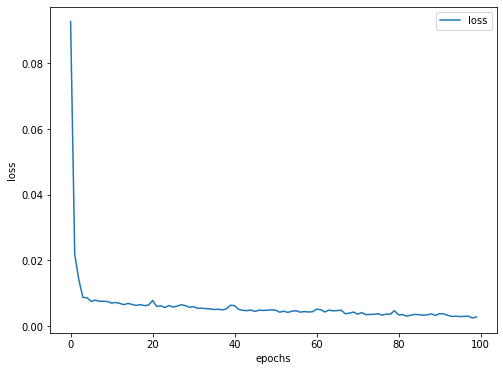

In [6379]:
losses = pd.DataFrame(model.history.history)
losses.plot(figsize=(8,6))
plt.ylabel('loss')
plt.xlabel('epochs')

In [6380]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

In [6381]:
# invert predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [6384]:
import math
from sklearn.metrics import accuracy_score,mean_squared_error

In [6385]:
import math
from sklearn.metrics import accuracy_score,mean_squared_error

print("Mean squared error for train set :" +math.sqrt(mean_squared_error(y_train,train_pred)))
print("Mean squared error for test set :" +math.sqrt(mean_squared_error(y_test,test_pred)))


72.03386192473187
73.75717794769976


# PLOT 

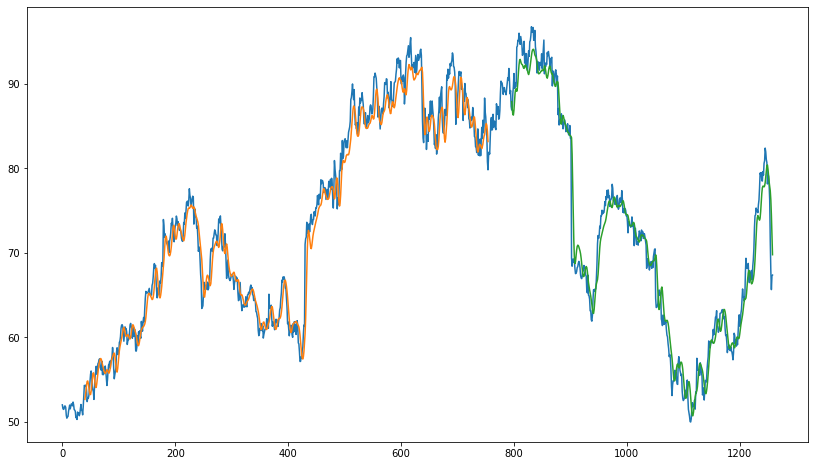

In [6386]:
lookback = time_step
train_pred_plot = np.empty_like(df_transformed)
train_pred_plot[:,:] = np.nan
train_pred_plot[lookback:len(train_pred)+lookback,:] = train_pred

test_pred_plot = np.empty_like(df_transformed)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred)+(lookback*2)+1:len(df_transformed),:] = test_pred

plt.figure(figsize=(14, 8))
plt.plot(scaler.inverse_transform(df_transformed))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)

# BOT

In [6388]:
test_pred = np.around(test_pred, decimals=0 )
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [6477]:
def buy_sell(values):
    bs = []
    action = []
    bs.append(0)
    for i in range(len(values)-1):
        if (values[i]<values[i+1]):
            bs.append(1)
        elif (values[i]==values[i+1]):
            last=bs[-1]
            bs.append(last)
        else:
            bs.append(2)
         
    if ((values[0]<values[1])or(values[0]==values[1])):
        action.append('Buy')
    else:
        action.append('Start')
    
    for j in range(1,(len(bs)-1)):
        if (bs[j]==0)and(bs[j+1]==2):
            action.append("Sell")
        elif(bs[j]==1)and(bs[j+1]==2):
            action.append("Sell")
        elif (bs[j]==2)and(bs[j+1]==1):
            action.append("Buy")
        
        else:
            action.append(".")
    action.append("Stop")
    
    return action,bs      

In [6406]:
trade_plan=buy_sell(test_pred)[0]

In [6475]:
def count(transaction):
    count_buy=0
    count_sell=0
    result=[]
    for i in transaction:
        if (i=="Buy"):
            count_buy=count_buy+1
        elif (i=="Sell"):
            count_sell=count_sell+1
    result.append(count_buy)
    result.append(count_sell)
    return result

In [6599]:
def trade(plan,real,buy_stocks_for):
    
    num_stocks=int(buy_stocks_for/real[0])
    profit=0
    if count(plan)[0]>count(plan)[1]:
        (plan)[-1]="Sell"
    
    for i in range(len(plan)):
        if (plan[i-1]=="Buy"):
            profit=profit-real[i-1]*num_stocks
        elif(plan[i-1]=="Sell"):
            profit=profit+real[i-1]*num_stocks
    
    buy=[]
    
    for k in range(len(plan)):
        if plan[k]=='Buy':
            buy.append(1)
        else:
            buy.append(0)

    invest=[]
    for l in buy:
        if l==1:
            invest.append(real[l]*num_stocks)
    average_investment = sum(invest)/len(invest)
    
    average_roi=profit/average_investment 
    print("Your profit is : ")
    print(profit)
    print("Your average return on investment : ")
    print(average_roi)
    return profit,average_roi

In [6600]:
trade(trade_plan,y_test,5000)

Your profit is : 
[1183.605]
Your average return on investment : 
[0.23873304]


(array([1183.605]), array([0.23873304]))

# History of Transactions

In [6555]:
derivative = buy_sell(test_pred)[1]
klm = pd.DataFrame(data=[trade_plan,test_pred,derivative,y_test])
pd.set_option("display.max_columns", None)
klm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462
0,Start,.,.,Buy,.,.,.,.,.,.,.,.,.,.,.,.,Sell,.,.,.,.,.,.,.,.,.,.,.,.,.,.,Buy,.,.,.,.,.,.,.,.,Sell,.,.,.,.,.,.,.,.,.,.,.,Buy,.,.,.,.,.,.,.,Sell,.,.,.,.,Buy,.,.,.,Sell,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,Buy,.,.,.,.,Sell,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,Buy,.,.,.,.,.,Sell,.,.,.,.,.,.,.,.,.,Buy,.,.,.,.,Sell,.,.,.,.,.,.,.,.,.,.,.,Buy,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,Sell,.,Buy,.,.,.,Sell,.,.,.,.,.,Buy,.,.,Sell,Buy,.,.,.,.,.,.,Sell,.,.,.,.,.,.,.,.,.,.,.,.,.,.,Buy,.,Sell,.,.,.,.,.,.,.,.,.,.,Buy,.,.,.,.,.,.,.,.,.,.,Sell,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,Buy,Sell,.,.,.,.,.,.,Buy,.,.,.,Sell,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,Buy,.,.,.,.,Sell,.,Buy,.,.,.,.,Sell,.,.,.,.,.,.,.,Buy,.,.,.,Sell,.,.,.,.,.,.,.,Buy,.,.,.,.,.,.,.,.,.,.,.,.,.,Sell,.,.,.,.,.,.,.,Buy,.,.,.,.,.,.,.,.,.,.,Sell,.,.,.,Buy,.,.,.,.,.,.,.,Sell,.,.,.,.,Buy,.,.,.,.,.,.,Sell,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,Buy,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,Sell,.,.,.,.,Buy,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,Sell,.,.,.,.,.,.,.,Stop
1,[88.0],[87.0],[86.0],[86.0],[87.0],[88.0],[89.0],[89.0],[89.0],[89.0],[89.0],[90.0],[91.0],[92.0],[93.0],[93.0],[93.0],[92.0],[92.0],[92.0],[92.0],[92.0],[92.0],[92.0],[92.0],[92.0],[92.0],[92.0],[92.0],[91.0],[91.0],[91.0],[92.0],[92.0],[93.0],[93.0],[94.0],[94.0],[94.0],[94.0],[94.0],[93.0],[93.0],[93.0],[93.0],[92.0],[92.0],[91.0],[91.0],[91.0],[91.0],[91.0],[91.0],[92.0],[92.0],[92.0],[92.0],[92.0],[92.0],[92.0],[92.0],[91.0],[91.0],[91.0],[91.0],[91.0],[92.0],[92.0],[92.0],[92.0],[91.0],[91.0],[91.0],[91.0],[90.0],[90.0],[90.0],[90.0],[90.0],[90.0],[90.0],[90.0],[90.0],[89.0],[88.0],[87.0],[86.0],[85.0],[85.0],[86.0],[86.0],[86.0],[86.0],[86.0],[85.0],[85.0],[85.0],[85.0],[85.0],[84.0],[84.0],[84.0],[84.0],[84.0],[84.0],[84.0],[84.0],[82.0],[78.0],[75.0],[71.0],[69.0],[69.0],[69.0],[70.0],[70.0],[71.0],[71.0],[71.0],[71.0],[70.0],[70.0],[70.0],[69.0],[69.0],[68.0],[67.0],[67.0],[67.0],[67.0],[68.0],[68.0],[68.0],[68.0],[68.0],[67.0],[66.0],[66.0],[66.0],[65.0],[65.0],[64.0],[64.0],[63.0],[63.0],[63.0],[63.0],[64.0],[65.0],[66.0],[66.0],[67.0],[67.0],[67.0],[68.0],[70.0],[71.0],[71.0],[72.0],[72.0],[72.0],[73.0],[73.0],[73.0],[73.0],[73.0],[74.0],[74.0],[74.0],[75.0],[75.0],[76

# Different stocks 

In [6732]:
def preprocess(df,splits,timestep):

    df=df[['date','close']]
    df=df.set_index('date')
    scaler = MinMaxScaler(feature_range=(0,1))
    df_transformed = scaler.fit_transform(np.array(df).reshape(-1,1))
    split = splits
    train_size,test_size = datasplit(splits)
    train = df_transformed[0:train_size,:]
    test = df_transformed[train_size+1:len(df_transformed),:]
    time_step = timestep
    x_train,y_train = create_dataset(train,time_step) 
    x_test,y_test = create_dataset(test,time_step)
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

    return x_train,y_train,x_test,y_test

In [6733]:
def model_for_df(x_train,y_train,x_test,y_test,epoch,batch):   
    
    callback = EarlyStopping(monitor='loss', patience=10)
    model = Sequential()
    model.add(LSTM(80,return_sequences = True, input_shape=(time_step,1)))
    model.add(Dropout(0.2))

    model.add(LSTM(80,return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(80,return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(80))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train,y_train,epochs=epoch,batch_size=batch,verbose=0,callbacks=[callback])
    
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)
    # invert predictions
    train_pred = scaler.inverse_transform(train_pred)
    test_pred = scaler.inverse_transform(test_pred)
    
    test_pred =np.around(test_pred, decimals=1 )
    
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
    
    return test_pred,train_pred,y_test,model

In [6734]:
def newdata(name,df,buy_stocks_for):
    
    df_x_train,df_y_train,df_x_test,df_y_test = preprocess(df,0.7,40)
    
    df_test_pred,df_train_pred,df_y_test,df_model = model_for_df(df_x_train,df_y_train,df_x_test,df_y_test,120,64)
    
    df_trade_plan = buy_sell(df_test_pred)[0]
    
    df_count=count(df_trade_plan)
    
    print(name)
    result = trade(df_trade_plan,df_y_test,buy_stocks_for)
    
    return result,df_model,df_count,df_trade_plan  

In [6735]:
def plot(df):
    df=df[['date','close']].set_index('date')
    return df.iplot()

In [6760]:
df_IBM = pd.read_csv('IBM_data.csv')
df_M = pd.read_csv('M_data.csv')
df_ZION = pd.read_csv('ZION_data.csv')
df_O = pd.read_csv('O_data.csv')
df_ORCL = pd.read_csv('ORCL_data.csv')
df_HCN = pd.read_csv('HCN_data.csv')
df_CVS = pd.read_csv('CVS_data.csv')
df_IT = pd.read_csv('IT_data.csv')
df_PH = pd.read_csv('PH_data.csv')
df_XL = pd.read_csv('XL_data.csv')
df_COTY = pd.read_csv("COTY_data.csv")
df_MMM = pd.read_csv("MMM_data.csv")
df_ROP = pd.read_csv("ROP_data.csv") 
df_TIF = pd.read_csv("TIF_data.csv")
df_XOM = pd.read_csv("XOM_data.csv")
df_TEL = pd.read_csv("TEL_data.csv")
df_XEL = pd.read_csv("XEL_data.csv")

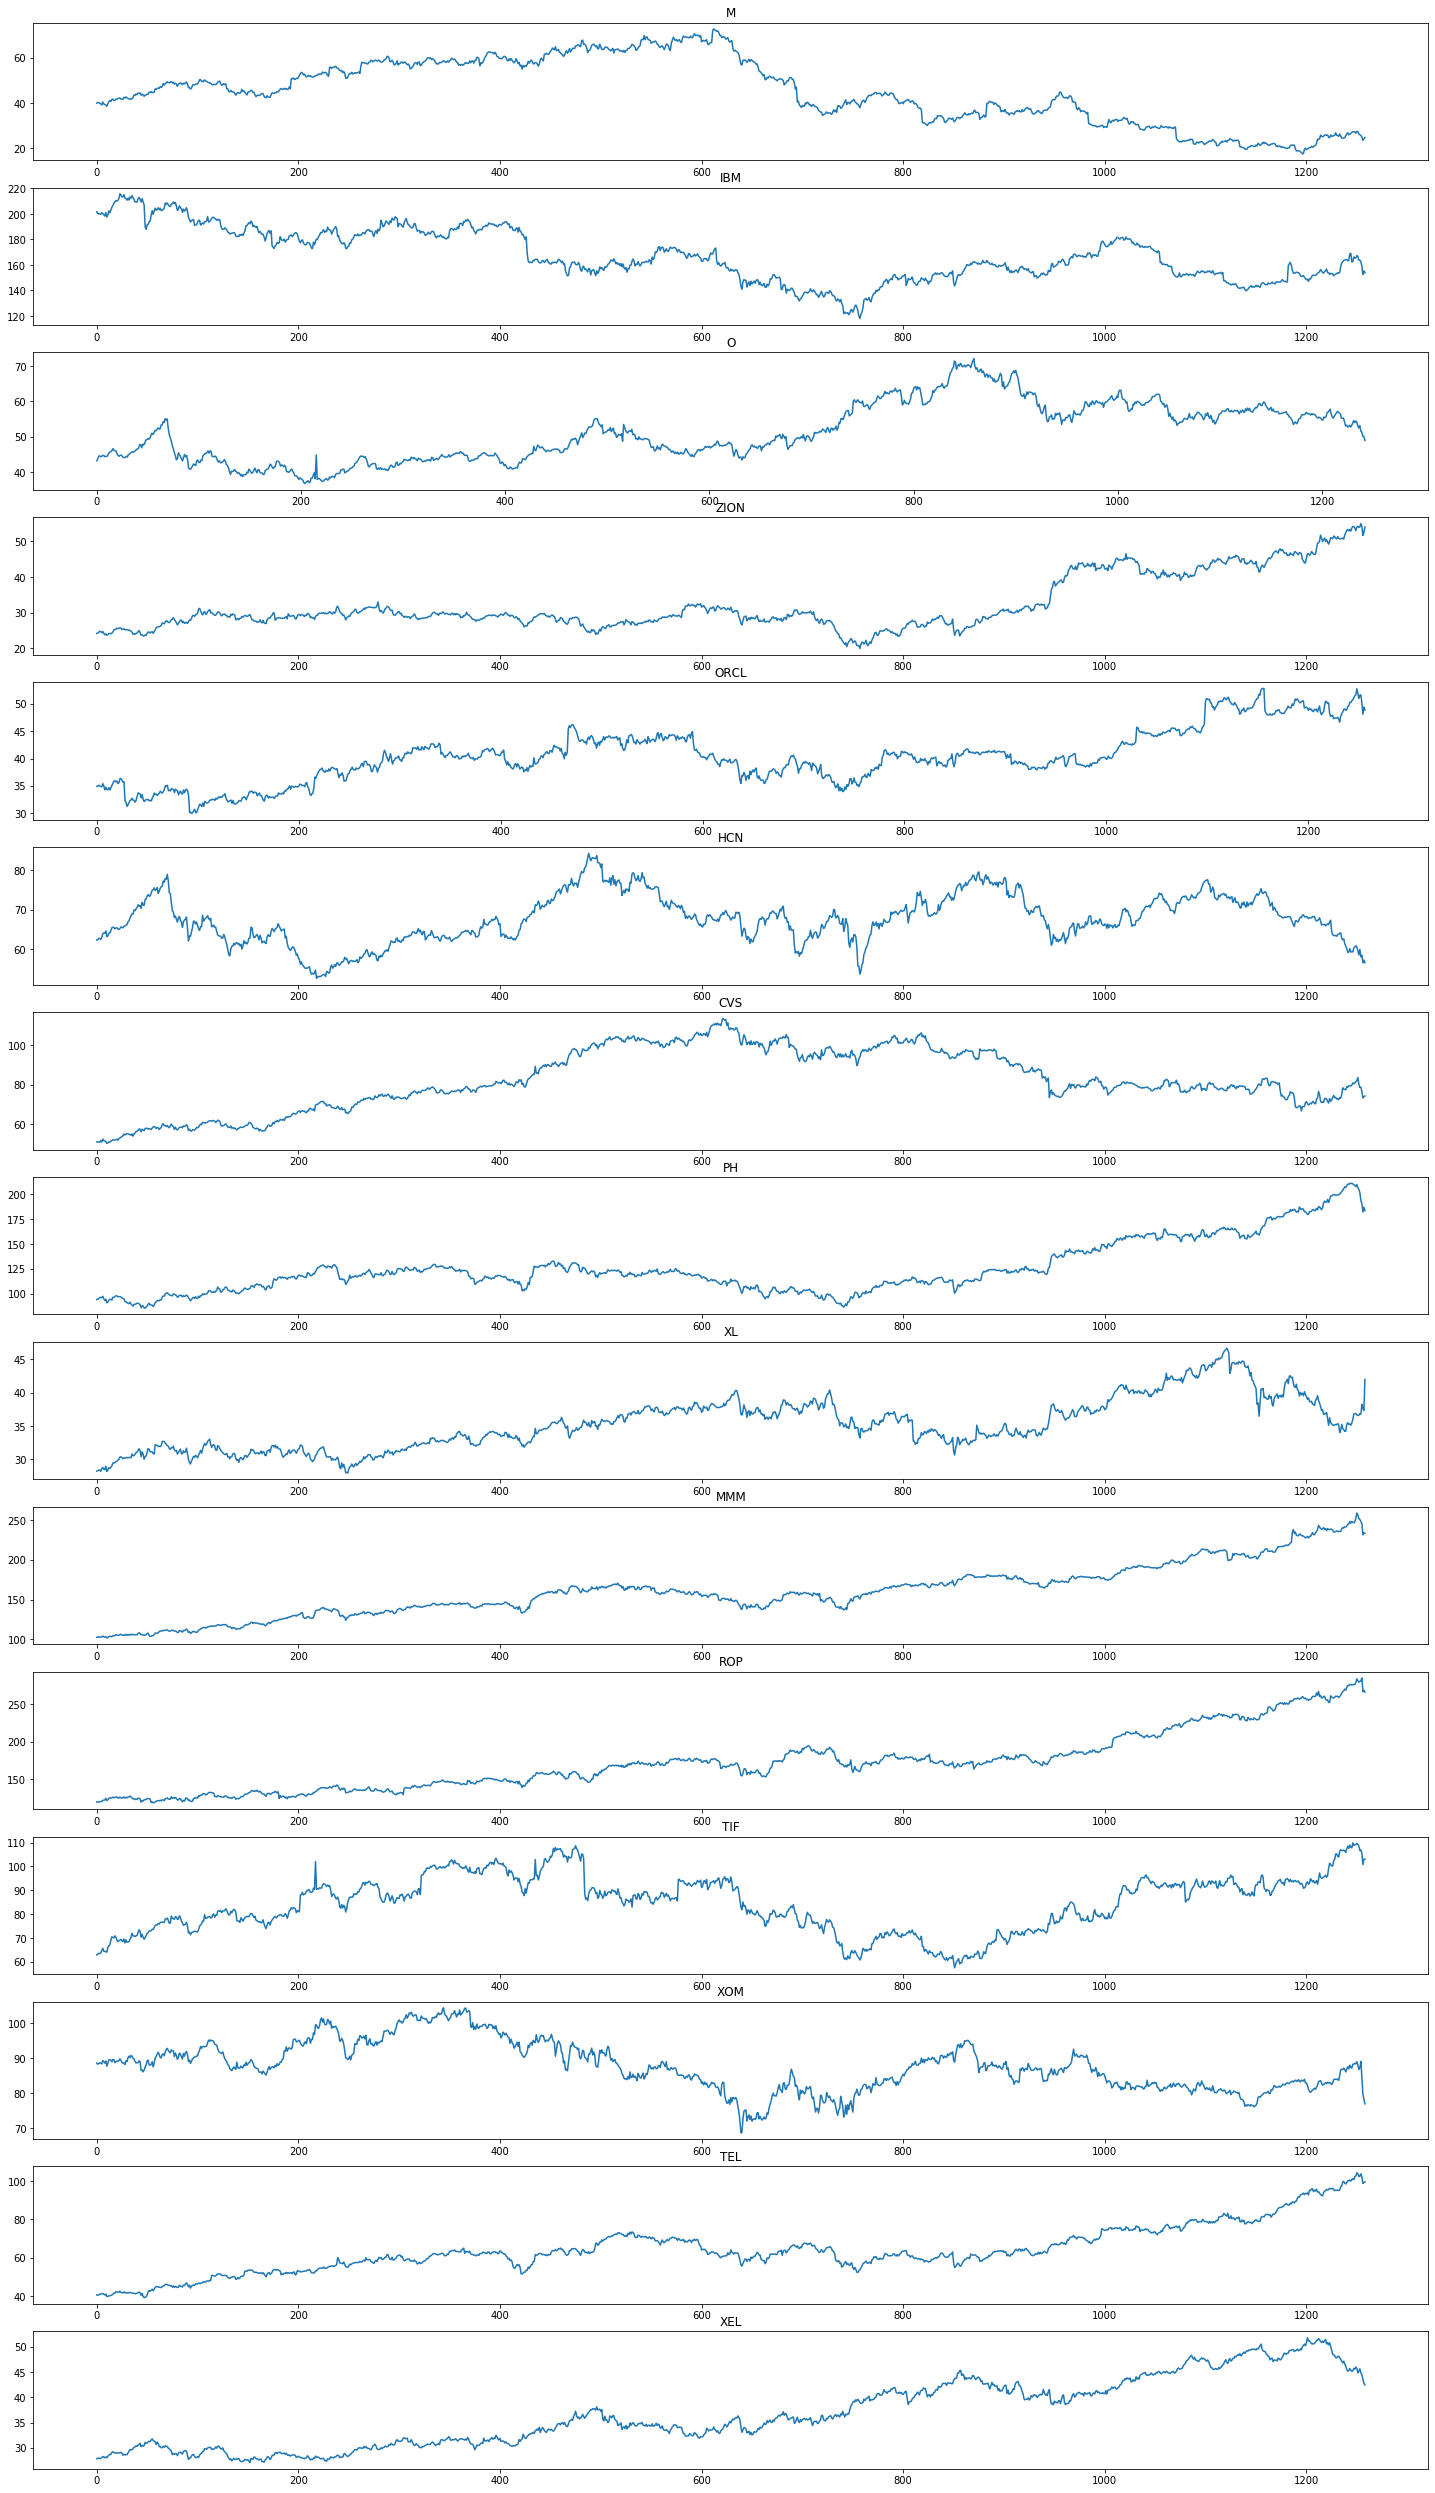

<Figure size 576x432 with 0 Axes>

In [6792]:
# Creating 15 subplots
fig, ax = plt.subplots(15,figsize=(25,45))
plt.figure(figsize=(8, 6))

ax[0].plot(df_M['close'])
ax[1].plot(df_IBM['close'])
ax[2].plot(df_O['close'])
ax[3].plot(df_ZION['close'])
ax[4].plot(df_ORCL['close'])
ax[5].plot(df_HCN['close'])
ax[6].plot(df_CVS['close'])
ax[7].plot(df_PH['close'])
ax[8].plot(df_XL['close'])
ax[9].plot(df_MMM['close'])
ax[10].plot(df_ROP['close'])
ax[11].plot(df_TIF['close'])
ax[12].plot(df_XOM['close'])
ax[13].plot(df_TEL['close'])
ax[14].plot(df_XEL['close'])

ax[0].title.set_text('M')
ax[1].title.set_text('IBM')
ax[2].title.set_text('O')
ax[3].title.set_text('ZION')
ax[4].title.set_text('ORCL')
ax[5].title.set_text('HCN')
ax[6].title.set_text('CVS')
ax[7].title.set_text('PH')
ax[8].title.set_text('XL')
ax[9].title.set_text('MMM')
ax[10].title.set_text('ROP')
ax[11].title.set_text('TIF')
ax[12].title.set_text('XOM')
ax[13].title.set_text('TEL')
ax[14].title.set_text('XEL')

In [6739]:
IBM = newdata('ibm',df_IBM,5000)

ibm
Your profit is : 
[725.93288821]
Your average return on investment : 
[0.14817309]


In [6740]:
M = newdata('m',df_M,5000)

m
Your profit is : 
[222.25170979]
Your average return on investment : 
[0.0445992]


In [6741]:
ZION = newdata('zion',df_ZION,5000)

zion
Your profit is : 
[865.13997719]
Your average return on investment : 
[0.17310861]


In [6742]:
O = newdata('o',df_O,5000)

o
Your profit is : 
[-288.2742132]
Your average return on investment : 
[-0.05738436]


In [6743]:
ORCL = newdata('orcl',df_ORCL,5000)

orcl
Your profit is : 
[1689.55303853]
Your average return on investment : 
[0.34819222]


In [6744]:
HCN = newdata('hcn',df_HCN,5000)

hcn
Your profit is : 
[-281.62105263]
Your average return on investment : 
[-0.05778099]


In [6745]:
CVS = newdata('cvs',df_CVS,5000)

cvs
Your profit is : 
[-674.34876033]
Your average return on investment : 
[-0.1353549]


In [6746]:
IT = newdata('it',df_IT,5000)

it
Your profit is : 
[439.88410889]
Your average return on investment : 
[0.08897717]


In [6747]:
PH = newdata('ph',df_PH,5000)

ph
Your profit is : 
[869.23852939]
Your average return on investment : 
[0.17711794]


In [6748]:
XL = newdata('xl',df_XL,5000)

xl
Your profit is : 
[904.74348663]
Your average return on investment : 
[0.17600679]


In [6754]:
MMM = newdata('mmm',df_MMM,5000)

mmm
Your profit is : 
[1740.08720041]
Your average return on investment : 
[0.3514588]


In [6751]:
ROP = newdata('rop',df_ROP,5000)

rop
Your profit is : 
[671.1324994]
Your average return on investment : 
[0.13665792]


In [6757]:
TIF = newdata('tif',df_TIF,5000)

tif
Your profit is : 
[996.04154198]
Your average return on investment : 
[0.19905525]


In [6753]:
XOM = newdata('xom',df_XOM,5000)

xom
Your profit is : 
[-297.7459714]
Your average return on investment : 
[-0.06035901]


In [6756]:
TEL = newdata('tel',df_TEL,5000)

tel
Your profit is : 
[678.09167382]
Your average return on investment : 
[0.13706087]


In [6761]:
XEL = newdata('xel',df_XEL,5000)

xel
Your profit is : 
[606.28978138]
Your average return on investment : 
[0.12282809]
